In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [18]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date

('2017-08-23')

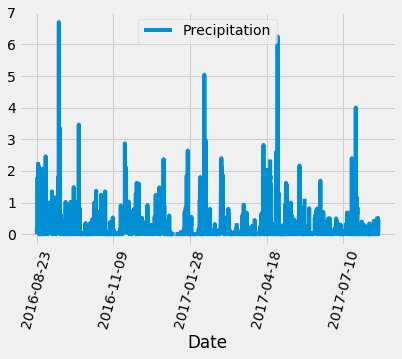

In [22]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Calculate the date 1 year ago from the last data point in the database
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=last_year).order_by(Measurement.date).all()
# print(precip_data)
# Perform a query to retrieve the data and precipitation scores

precip_df = pd.DataFrame(precip_data)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df.set_index('date').head()
# Sort the dataframe by date
precip_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot('date', 'prcp')
plt.legend(['Precipitation'])
plt.xlabel('Date')
plt.xticks(rotation=75)
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ma_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
ma_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stats = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),]
all_stats = session.query(*stats).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
all_stats

('USC00519281', 54.0, 85.0, 71.66378066378067)

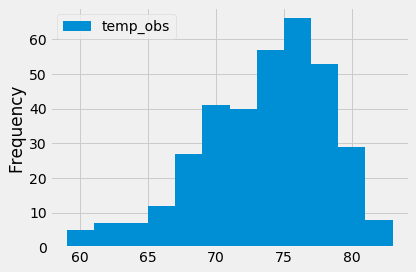

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_station = all_stats[0]

temp_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == high_station).filter(Measurement.date >= last_year).order_by(Measurement.date).all()
temp_obs_df = pd.DataFrame(temp_obs, columns=["date","temp_obs"])
temp_obs_df.plot.hist(bins=12)
plt.tight_layout()

plt.show()



In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
avg_t=calc_temps('2016-08-23', '2017-08-23')
print(avg_t)

[(58.0, 74.59058295964125, 87.0)]


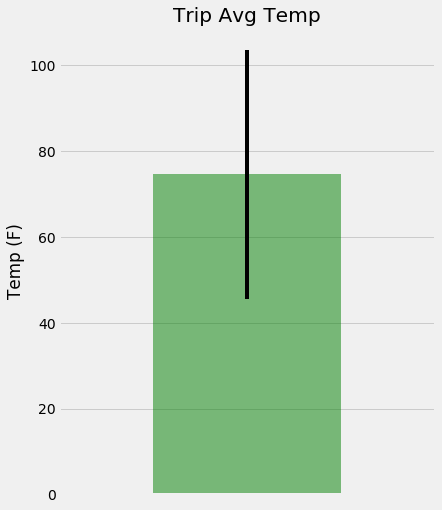

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)




trip_df = pd.DataFrame(avg_t, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='green')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.show()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rfps = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()
print(rfps)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, None)]


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_day = '2017-04-10'
end_day = '2017-04-18'
# Use the start and end date to create a range of dates
days=session.query(Measurement.date).filter(Measurement.date >= start_day).filter(Measurement.date<=end_day).group_by(Measurement.date).all()
# Stip off the year and save a list of %m-%d strings

holiday = [h[0] for h in days]
holiday_prep=[h[5:]for h in holiday]


first_day = holiday_prep[0]
final_day = holiday_prep[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= first_day).filter(func.strftime("%m-%d", Measurement.date) <= final_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals =daily_normals[0]
print("Daily Normals for vacation")
for d, day in enumerate(daily_normals):
    print(f"Day {d +1} of vacation {daily_normals[d]}")



Daily Normals for vacation
Day 1 of vacation (64.0, 71.40350877192982, 79.0)
Day 2 of vacation (65.0, 72.49180327868852, 82.0)
Day 3 of vacation (65.0, 72.22413793103448, 80.0)
Day 4 of vacation (64.0, 71.52542372881356, 79.0)
Day 5 of vacation (65.0, 72.75, 81.0)
Day 6 of vacation (61.0, 71.79310344827586, 79.0)
Day 7 of vacation (62.0, 71.55357142857143, 81.0)
Day 8 of vacation (65.0, 71.93103448275862, 77.0)
Day 9 of vacation (67.0, 72.49152542372882, 77.0)


In [55]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_normals_df = pd.DataFrame(daily_normals,columns = ["Minimum Temp ", "Average Temp","Maximum Temp"])
temp_normals_df['Date']= holiday

# temp_normals_df['Date'] = pd.to_datetime(temp_normals_df['Date'], format='%Y-%m-%d')
temp_normals_df.set_index('Date')

,Minimum Temp,Average Temp,Maximum Temp
Date,,,
2017-04-10,64.0,71.403509,79.0
2017-04-11,65.0,72.491803,82.0
2017-04-12,65.0,72.224138,80.0
2017-04-13,64.0,71.525424,79.0
2017-04-14,65.0,72.750000,81.0
2017-04-15,61.0,71.793103,79.0
2017-04-16,62.0,71.553571,81.0
2017-04-17,65.0,71.931034,77.0
2017-04-18,67.0,72.491525,77.0


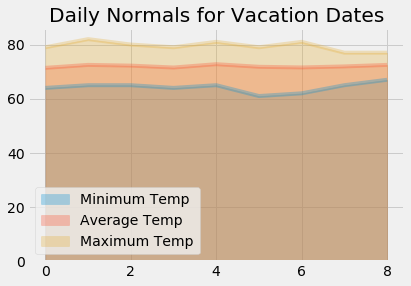

In [60]:
# Plot the daily normals as an area plot with `stacked=False`
temp_normals_df.plot(kind='area', alpha=.3, stacked=False, x_compat=True, title="Daily Normals for Vacation Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()
